# <span style="color:#64943E">Vehicle Loan Prediction avec Fastai</span> 🚗🏦📊

**Problématique:**  

> A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date.

**Lien aux donées:**

https://www.kaggle.com/avikpaul4u/vehicle-loan-default-prediction

**Méthodologie "Experimental Setup"**

1. [x] Shuffle data (seed = 2019)
2. [x] Define a Hold-Out set <span style="color:#ff0000">TO BE DETERMINED</span> 10%
3. [ ] Evaluation Metric of Choice: <span style="color:#ff0000">TO BE DETERMINED</span> F1-measure, Accuracy, Average-Recall, ROC?
4. [ ] All Features VS Feature Importance
5. [ ] Fall Features VS Feature Engineering
6. [ ] Balance VS As-Is

**Questionnement Fastai**  

1. [ ] learning rate finder
2. [ ] plot confusion matrix
3. [ ] modify weighting of loss function for classes

**Conventions:**
>  
Training set > Validation set > Testing set (e.g. Hold-Out set)

### 0. Import libraries and data

In [14]:
# Manipulation des données
import pandas as pd

# Préparation données
from sklearn.model_selection import train_test_split

# Fast ai - tabular models
from fastai import *
from fastai.tabular import *

In [20]:
data = pd.read_csv('train.csv')

In [23]:
#data.to_parquet('VLDP.parquet.gzip')

pd.read_parquet('VLDP.parquet.gzip')

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,34,20700,48,1050,01-08-88,Salaried,...,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0
233150,606141,73651,100600,74.95,34,23775,51,990,05-12-88,Self employed,...,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0
233151,613658,33484,71212,48.45,77,22186,86,2299,01-06-76,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
233152,548084,34259,73286,49.10,77,22186,86,2299,26-03-94,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


### 1. Shuffle data

In [3]:
data = data.sample(frac=1, random_state=2019).reset_index(drop=True)

### preprocessing
data.drop('UniqueID', axis=1, inplace=True)  # Just unique values, no pattern

df_TEMP1 = data['AVERAGE.ACCT.AGE'].str.split('yrs|mon',expand=True)
data['AVERAGE.ACCT.AGE.YRS'] = df_TEMP1[0].astype(int)
data['AVERAGE.ACCT.AGE.MON'] = df_TEMP1[1].astype(int)
data.drop('AVERAGE.ACCT.AGE', axis = 1, inplace=True)

df_TEMP2 = data['CREDIT.HISTORY.LENGTH'].str.split('yrs|mon',expand=True)
data['CREDIT.HISTORY.YRS'] = df_TEMP2[0].astype(int)
data['CREDIT.HISTORY.MON'] = df_TEMP2[1].astype(int)
data.drop('CREDIT.HISTORY.LENGTH', axis = 1, inplace=True)

X = data.copy()
y = X['loan_default']

### 2. Define Hold-Out data

In [4]:
train_df, test_df = train_test_split(X, test_size=0.10, random_state=2019, stratify=y)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# X_trainval = X.iloc[indexes[0]]
# X_test = X.iloc[indexes[1]]

stratify = yes 

Cela veux dire de garder la meme proportion des classes lors du split

In [8]:
len(indexes[0]), len(indexes[1])

(209838, 23316)

# Fast AI

In [5]:
# Split Training - Validation
train_df_idx, validation_df_idx = train_test_split(train_df.index, test_size=0.20, random_state=2019, stratify=train_df['loan_default'])

In [6]:
# Define the dependent variable
dep_var = 'loan_default'

# Define the continuous variables
cont_names = ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE', 'PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT',
             'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
             'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES',
             'CREDIT.HISTORY.YRS', 'CREDIT.HISTORY.MON','AVERAGE.ACCT.AGE.YRS','AVERAGE.ACCT.AGE.MON']

# Define the categorical variables
cat_names = [c_name for c_name in X.columns if c_name not in cont_names and c_name !='loan_default']

# Define the tabular processes
procs = [FillMissing, Categorify, Normalize]

Le but d'utiliser des embeddings pour les valeurs categoriques, c'est qu'on pourra apprendre sur certains aspects.

Prenon branch_id par exemple. On espere que la notion d'emplacement sera peut etre capturer dans l'une des dimmensions du vecteur.

Par la suite on "concat" les embeddings de chaque.

<span style="color:#ff0000">Do you define the processes before the splitting of data or after???</span>

In [7]:
data = (TabularList.from_df(df=train_df, path='./', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(validation_df_idx)
                           .label_from_df(cols=dep_var)
                           #.add_test(test)
                           .databunch())

In [71]:
#data.show_batch(rows=10)

branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.INSTAL.AMT,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,CREDIT.HISTORY.YRS,CREDIT.HISTORY.MON,AVERAGE.ACCT.AGE.YRS,AVERAGE.ACCT.AGE.MON,target
14,14198,86,823,01-01-67,Self employed,31-10-18,15,3034,1,1,0,0,0,0,K-High Risk,9,3,0,572407,0,0,0,0,0.3813,-0.3206,0.9742,0.3608,0.3732,0.2932,-0.0335,-0.0421,-0.0417,-0.0130,1.6793,2.3457,3.9234,0.8198,1.2656,0.4172,-0.1814,0
136,23993,45,4301,01-01-87,Salaried,07-08-18,8,2060,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,-0.0678,-0.7264,1.1936,-0.8569,-0.1723,-0.1785,-0.0335,-0.0421,-0.0417,-0.0834,-0.4002,-0.2537,-0.2906,-0.5065,-0.7063,-0.4555,-0.7370,1
48,23909,120,6298,01-01-83,Self employed,25-09-18,5,2216,1,0,0,1,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0.5516,0.4888,0.0409,-0.8569,-0.1723,-0.1785,-0.0335,-0.0421,-0.0417,-0.0834,-0.4002,-0.2537,-0.2906,-0.5065,-0.7063,-0.4555,-0.7370,0
135,23003,86,1703,12-02-82,Self employed,28-09-18,4,1823,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,-0.6258,-0.0994,-0.8654,-0.8569,-0.1723,-0.1785,-0.0335,-0.0421,-0.0417,-0.0834,-0.4002,-0.2537,-0.2906,-0.5065,-0.7063,-0.4555,-0.7370,1
16,21124,86,2975,13-09-88,Salaried,31-10-18,14,908,1,1,0,0,0,0,Not Scored: Not Enough Info available on the customer,1,1,0,64000,0,0,0,0,0.6897,0.0646,0.7225,-0.8066,-0.1065,-0.1258,-0.0335,-0.0421,-0.0417,-0.0834,0.6395,-0.2537,-0.2906,-0.5065,-0.7063,-0.4555,-0.7370,1
248,15680,45,1784,06-01-92,Salaried,26-09-18,4,364,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0.2991,-0.3119,0.8938,-0.8569,-0.1723,-0.1785,-0.0335,-0.0421,-0.0417,-0.0834,-0.4002,-0.2537,-0.2906,-0.5065,-0.7063,-0.4555,-0.7370,0
11,24305,86,5977,27-02-92,Self employed,06-10-18,3,164,1,1,0,0,0,0,F-Low Risk,6,2,1,134000,0,0,0,0,0.2841,1.7830,-1.7420,1.1440,-0.1111,-0.0681,-0.0335,-0.0421,-0.0417,0.0353,0.6395,-0.2537,-0.2906,0.3777,0.1388,0.4172,-0.1814,1
61,15919,45,1359,14-12-90,Self employed,28-10-18,6,1689,1,1,0,0,0,0,A-Very Low Risk,3,0,0,0,0,0,0,0,-0.0619,-0.5598,0.8230,1.6405,-0.1723,-0.1785,-0.0335,-0.0421,-0.0417,-0.0658,-0.4002,-0.2537,-0.2906,1.2619,-0.7063,0.4172,1.7633,0
18,14115,86,2687,03-01-58,Self employed,23-08-18,4,1782,1,1,0,0,0,0,Not Scored: Only a Guarantor,1,1,0,130000,0,0,0,0,-0.2706,-0.4191,0.1510,-0.8155,-0.1437,-0.0714,-0.0335,-0.0421,-0.0417,-0.0637,-0.4002,-0.2537,-0.2906,1.2619,-0.7063,3.0352,-0.7370,0
165,21216,45,6505,01-01-63,Self employed,30-09-18,5,1466,1,0,0,1,0,0,I-Medium Risk,3,1,0,22000,0,0,0,0,1.5091,0.6427,0.9078,0.9076,-0.1562,-0.1604,-0.0335,-0.0421,-0.0417,-0.0834,-0.4002,-0.2537,-0.2906,0.8198,0.9839,2.1626,0.0964,1


There isn't much documentation on the layer size to specify after the embeddings. Jeremy did specify however that it is best to create a big network, but add regularization.

In [23]:
learn = tabular_learner(data, layers=[1000, 500], ps=[0.001,0.01], emb_drop=0.04,  metrics=accuracy)

In [92]:
?tabular_learner

Signature:
tabular_learner(
    data: fastai.basic_data.DataBunch,
    layers: Collection[int],
    emb_szs: Dict[str, int] = None,
    metrics=None,
    ps: Collection[float] = None,
    emb_drop: float = 0.0,
    y_range: Union[Tuple[float, float], NoneType] = None,
    use_bn: bool = True,
    **learn_kwargs,
)
Docstring: Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params.
File:      ~/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/tabular/learner.py
Type:      function


In [9]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(83, 19)
    (1): Embedding(2906, 139)
    (2): Embedding(11, 6)
    (3): Embedding(6419, 217)
    (4): Embedding(14947, 348)
    (5): Embedding(3, 3)
    (6): Embedding(85, 19)
    (7): Embedding(23, 9)
    (8): Embedding(3255, 148)
    (9): Embedding(2, 2)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(21, 9)
    (16): Embedding(105, 22)
    (17): Embedding(40, 13)
    (18): Embedding(21, 9)
    (19): Embedding(36084, 570)
    (20): Embedding(37, 12)
    (21): Embedding(22, 9)
    (22): Embedding(10, 6)
    (23): Embedding(1456, 95)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=1687, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, mome

L'utilisation d'embedding pour des valeurs categorique permet de capturer des relations entres la valeurs. Par exemple, Samedi et Dimanche sont peut etre similaire, et que vendredi il s'agit d'un comportement entre-deux de la semaine et la fin de semaine [1].

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


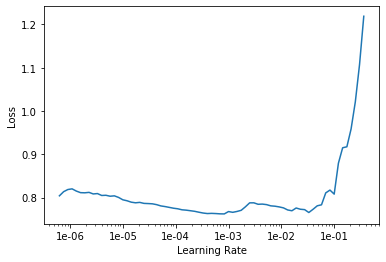

In [25]:
learn.recorder.plot()

In [26]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.493745,0.801691,0.782835,01:00


# See the embeddings learnt!

In [77]:
interp = ClassificationInterpretation.from_learner(learn)

In [81]:
from fastai.widgets import ClassConfusion
#ClassConfusion(interp, ['0', '1'], figsize=(12,12), varlist=['disbursed_amount', 'asset_cost', 'State_ID'])

In [83]:
from itertools import product

In [87]:
couche_1 = [100, 50]
couche_2 = [50, 20, 10]

for pair in list(product(couche_1,couche_2)):
    print(pair)
    learn = tabular_learner(data, layers=[pair[0],pair[1]], metrics=accuracy)
    learn.fit(1, 1e-2)

(100, 50)


epoch,train_loss,valid_loss,accuracy,time
0,0.494875,0.501996,0.782978,01:01


(100, 20)


epoch,train_loss,valid_loss,accuracy,time
0,0.499843,0.497533,0.783120,01:01


(100, 10)


epoch,train_loss,valid_loss,accuracy,time
0,0.498461,0.498330,0.783025,01:02


(50, 50)


epoch,train_loss,valid_loss,accuracy,time
0,0.498583,0.497705,0.783621,01:01


(50, 20)


epoch,train_loss,valid_loss,accuracy,time
0,0.495997,0.499312,0.780666,00:59


(50, 10)


epoch,train_loss,valid_loss,accuracy,time
0,0.481359,0.498510,0.783478,01:01


https://forums.fast.ai/t/how-to-deal-with-unbalanced-data-classes-in-image-classification/14343

weights = [w1, w2, w3, ...]
class_weights = torch.FloatTensor(weights)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)
where you weight w1, w2, w3 in whatever way you wish. I’ve worked with sample size / (num classes * class frequency) but have to admit I’ve not had much luck getting class weighting to work well.


....

https://www.kaggle.com/ccjoshua/credit-card-fraud-using-fastai-tabular

In [4]:
# ![image](https://user-images.githubusercontent.com/25487881/72295443-9766ad80-3625-11ea-85d5-627013dac6f4.pn g)

[1] https://www.fast.ai/2018/04/29/categorical-embeddings/